In [129]:
#Code below creates bar location list

import pandas as pd
df_liquor = pd.read_csv('https://data.ny.gov/api/views/hrvs-fxs2/rows.csv?accessType=DOWNLOAD')

#Applies filters
mask = ((df_liquor["Latitude"] != 0) & 
        (df_liquor["Longitude"] != 0) & 
        (df_liquor["Agency Zone Office Name"] == "New York City") &
        (df_liquor["License Class Code"] == 252))
df_liquor = df_liquor[mask]

#Drops missing lat/long entries
df_liquor = df_liquor.dropna(subset=['Latitude','Longitude'])

#Creates list-of-lists of bar locations to use later
lats = df_liquor['Latitude'].tolist()
lons = df_liquor['Longitude'].tolist()
bar_locs = [list(i) for i in zip(lats,lons)]

In [130]:
#Fn for distance in km (takes two lat/long coord pairs)
from math import radians, sin, cos, acos

def distance(lat1,lon1,lat2,lon2):
  
    slat = radians(float(lat1))
    slon = radians(float(lon1))
    elat = radians(float(lat2))
    elon = radians(float(lon2))

    dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
    return(dist)

#Fn for finding number of bars within r km of a station
#Fn args -> 1) station's lat, 2) station's long, 3) a list of bar locations (2-element lists), 4) radius (in km)
def nearby_count(station_lat,station_lon,bar_loc_list,radius):
    nearby_bar_count = 0
    for bar in bar_locs:
        if distance(station_lat,station_lon,bar[0],bar[1]) < radius:
            nearby_bar_count += 1
    return(nearby_bar_count)


In [143]:
#Pulls latest CSV (d/led from Google Drive and placed in directory)
df_mta = pd.read_csv('mta_busiest_latlong.csv')

#Count # bars within quarter and half km; then calc "entries/#proximate bars" cols
df_mta['Bars Within .25 km'] = df_mta.apply(lambda x: nearby_count(x['Station Latitude'], x['Station Longitude'],bar_locs,.25), axis=1)
df_mta['Bars Within .50 km'] = df_mta.apply(lambda x: nearby_count(x['Station Latitude'], x['Station Longitude'],bar_locs,.5), axis=1)
df_mta['EBRatio_.25km'] = round(df_mta['DAILY_ENTRIES']/df_mta['Bars Within .25 km'],2)
df_mta['EBRatio_.50km'] = round(df_mta['DAILY_ENTRIES']/df_mta['Bars Within .50 km'],2)

#Remove stations with no bars nearby
df_mta = df_mta[(df_mta["Bars Within .50 km"] != 0)]

#Add col for entries rank (ranking stat not used for any calcs)
df_mta['ENTRIES_RANK'] = df_mta['DAILY_ENTRIES'].rank(ascending=0) 

#Sort by EBRatio
df_mta = df_mta.sort_values(by='EBRatio_.50km',ascending = False)

In [139]:
df_mta_qtrkm = df_mta.sort_values(['EBRatio_.25km'],ascending = False)
df_mta_qtrkm

,Unnamed: 0,STATION_LINE,DAILY_ENTRIES,LL_NAME,Station Latitude,Station Longitude,Bars Within .25 km,Bars Within .50 km,EBRatio_.25km,EBRatio_.50km,ENTRIES_RANK
11,11,96 ST,6682137.0,96th St,40.790857,-73.964024,0,1,inf,6682137.00,12.0
27,27,7 AV,4152099.0,7th Av,40.695408,-73.979552,0,5,inf,830419.80,27.0
7,7,125 ST,8301242.0,125th St,40.809510,-73.948289,2,23,4150621.00,360923.57,8.0
30,30,145 ST,3862698.0,145th St,40.823849,-73.943181,1,9,3862698.00,429188.67,30.0
34,34,DEKALB AV,3484258.0,DeKalb Av,40.698164,-73.945596,1,2,3484258.00,1742129.00,33.0
36,36,JAMAICA CENTER,3444604.0,Parsons Blvd-Archer Av - Jamaica Center,40.702147,-73.801109,1,4,3444604.00,861151.00,35.0
49,49,CROWN HTS-UTICA,2690175.0,Utica Av,40.672703,-73.932137,1,3,2690175.00,896725.00,45.0
35,35,116 ST,3473348.0,116th St,40.801937,-73.948708,2,12,1736674.00,289445.67,34.0
46,46,KINGS HWY,2802934.0,Kings Highway,40.605192,-73.969261,2,8,1401467.00,350366.75,42.0
48,48,KEW GARDENS,2704673.0,Kew Gardens-Union Turnpike,40.714441,-73.831008,2,2,1352336.50,1352336.50,44.0


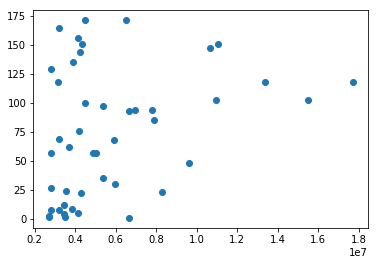

In [136]:
#Throwaway
#Scatter of entries vs. nearby bars
import matplotlib.pyplot as plt

entries = df_mta['DAILY_ENTRIES'].tolist()
nearby = df_mta['Bars Within .50 km'].tolist()

plt.scatter(entries,nearby)
plt.show()

In [ ]:
#Throwaway
ST_125 = [40.811109,-73.952343] #Location of 125th St Station
[i for i in bar_locs if distance(ST_125[0],ST_125[1],i[0],i[1]) < 1] #Bars within 1km of 125th St Station

In [146]:
df_mta.to_csv('MTA_BarRankings.csv')